Using device: cuda (Mode: Temperature Annealing)
Training...
Step 0: Loss 725.66 | Mask Std: 0.0046 | Temp: 1.0000
Step 200: Loss 156.11 | Mask Std: 0.0020 | Temp: 0.9010
Step 400: Loss 111.22 | Mask Std: 0.0023 | Temp: 0.8020
Step 600: Loss 79.83 | Mask Std: 0.0026 | Temp: 0.7030
Visualizing...


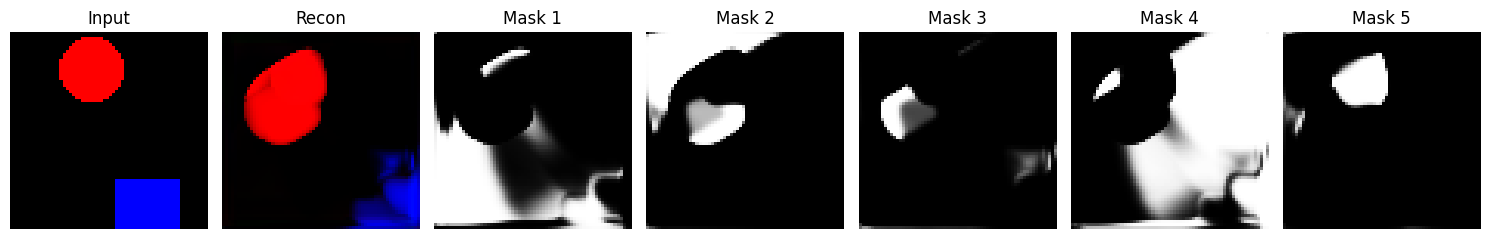

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random

# ==========================================
# 1. データセット (変更なし)
# ==========================================
class RandomShapesDataset(Dataset):
    def __init__(self, size=(64, 64), length=30000): 
        self.size = size
        self.length = length

    def __getitem__(self, idx):
        img = Image.new("RGB", self.size, (0, 0, 0))
        draw = ImageDraw.Draw(img)
        ox, oy = random.randint(-8, 8), random.randint(-8, 8)
        
        # 赤丸
        draw.ellipse((10+ox, 10+oy, 30+ox, 30+oy), fill=(255, 0, 0))
        # 青四角
        draw.rectangle((40-ox, 40-oy, 60-ox, 60-oy), fill=(0, 0, 255))
        
        return transforms.ToTensor()(img)

    def __len__(self):
        return self.length

# ==========================================
# 2. Slot Attention (温度可変対応)
# ==========================================
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, hidden_dim=64):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5

        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, dim)
        )

    # forwardで温度(current_temp)を受け取る
    def forward(self, inputs, current_temp, num_slots=None):
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        inputs = self.norm_input(inputs)
        
        # Random Init
        slots = torch.randn(b, n_s, d, device=inputs.device)

        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            
            # ★温度アニーリング適用
            attn = (dots / current_temp).softmax(dim=1) + 1e-8
            
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
            
        return slots

# ==========================================
# 3. Model
# ==========================================
class SlotModel(nn.Module):
    def __init__(self, resolution=(64, 64), num_slots=5, hidden_dim=32):
        super().__init__()
        self.resolution = resolution
        self.num_slots = num_slots
        self.hidden_dim = hidden_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 5, padding=2), nn.ReLU(), 
        )
        self.pos_emb = nn.Parameter(torch.randn(1, hidden_dim, resolution[0], resolution[1]) * 0.01)

        self.slot_attention = SlotAttention(num_slots, hidden_dim, iters=5, hidden_dim=64)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim + 2, 32, 5, padding=2), nn.ReLU(), 
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 4, 3, padding=1),
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0)
        grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return grid

    def forward(self, x, current_temp):
        b, c, h, w = x.shape
        grid = self.build_grid(b, (h, w), x.device)
        x_with_grid = torch.cat([x, grid], dim=1)
        
        x_enc = self.encoder(x_with_grid)
        x_enc = x_enc + self.pos_emb
        x_flat = x_enc.permute(0, 2, 3, 1).reshape(b, -1, self.hidden_dim)
        
        # 温度を渡す
        slots = self.slot_attention(x_flat, current_temp)

        slots_img = slots.view(b * self.num_slots, self.hidden_dim, 1, 1).repeat(1, 1, h, w)
        grid_flat = self.build_grid(b * self.num_slots, (h, w), x.device)
        slots_with_grid = torch.cat([slots_img, grid_flat], dim=1)
        
        out = self.decoder(slots_with_grid)
        out = out.view(b, self.num_slots, 4, h, w)
        
        recons = out[:, :, :3, :, :]
        masks = out[:, :, 3:4, :, :]
        # マスク表示用の温度は固定でも良いが、学習と同じにしておく
        masks = torch.softmax(masks / current_temp, dim=1)
        
        recon_combined = torch.sum(recons * masks, dim=1)
        return recon_combined, recons, masks

# ==========================================
# 4. 実行パート (アニーリング実装)
# ==========================================
def run_annealing():
    torch.manual_seed(99) 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device} (Mode: Temperature Annealing)")

    dataset = RandomShapesDataset(length=50000)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

    model = SlotModel(resolution=(64, 64), num_slots=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0004)

    print("Training...")
    model.train()
    
    total_steps = 2000 # 総ステップ数
    start_temp = 1.0   # 最初は熱く（灰色容認）
    end_temp = 0.01    # 最後は冷たく（白黒ハッキリ）

    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        
        # ★温度スケジューリング (線形減衰)
        # iが増えるにつれて 1.0 -> 0.01 に下がる
        progress = min(1.0, i / total_steps)
        current_temp = start_temp * (1 - progress) + end_temp * progress
        
        optimizer.zero_grad()
        recon, _, masks = model(batch, current_temp)
        loss = ((batch - recon)**2).sum()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if i % 200 == 0:
            mask_std = masks.std().item()
            print(f"Step {i}: Loss {loss.item()/64:.2f} | Mask Std: {mask_std:.4f} | Temp: {current_temp:.4f}")
        
        if i >= total_steps:
            break

    print("Visualizing...")
    model.eval()
    test_img = dataset[0].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # 推論時は少し低めの温度でクッキリさせる
        recon, _, masks = model(test_img, current_temp=0.01)
    
    img_np = test_img[0].permute(1, 2, 0).cpu().numpy()
    recon_np = recon[0].permute(1, 2, 0).cpu().clip(0, 1).numpy()
    masks_np = masks[0, :, 0].cpu().numpy()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 7, 1); plt.imshow(img_np); plt.title("Input"); plt.axis('off')
    plt.subplot(1, 7, 2); plt.imshow(recon_np); plt.title("Recon"); plt.axis('off')
    
    for k in range(5):
        plt.subplot(1, 7, k+3)
        plt.imshow(masks_np[k], cmap='gray', vmin=0, vmax=1)
        plt.title(f"Mask {k+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_annealing()